<a href="https://www.kaggle.com/code/kamalapousajja/house-price-prediction-top8?scriptVersionId=158411362" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# House Price Prediction

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from catboost import Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
# Read the data

df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
# Merge the data so we can process them together

df_full = pd.concat([df_train, df_test])

In [4]:
df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [5]:
# Get the shape of the data

df_full.shape

(2919, 80)

In [6]:
# Get some information about the data

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [7]:
# The statistical summary of the numeric data

df_full.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [8]:
# Try to chage the display format by using .Transpose

df_full.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


In [9]:
# The statistical summary of the categorical data

df_full.select_dtypes(include=[object]).describe().T

,count,unique,top,freq
MSZoning,2915,5,RL,2265
Street,2919,2,Pave,2907
Alley,198,2,Grvl,120
LotShape,2919,4,Reg,1859
LandContour,2919,4,Lvl,2622
Utilities,2917,2,AllPub,2916
LotConfig,2919,5,Inside,2133
LandSlope,2919,3,Gtl,2778
Neighborhood,2919,25,NAmes,443
Condition1,2919,9,Norm,2511


In [10]:
# Find the missing values

missing_sum = df_full.isnull().sum().sort_values(ascending=False)

missing_sum.head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
BsmtFullBath        2
Functional          2
Exterior2nd         1
Exterior1st         1
GarageArea          1
GarageCars          1
SaleType            1
KitchenQual         1
BsmtFinSF1          1
Electrical          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
TotRmsAbvGrd        0
Fireplaces          0
SaleCondition       0
PavedDrive          0
MoSold              0
dtype: int64

In [11]:
# Percentage of the missing values in each column

missing_percent = ((df_full.isnull().sum() / len(df_full)) *100).round(2).sort_values(ascending=False)

missing_percent.head(40)

PoolQC           99.66
MiscFeature      96.40
Alley            93.22
Fence            80.44
MasVnrType       60.50
SalePrice        49.98
FireplaceQu      48.65
LotFrontage      16.65
GarageFinish      5.45
GarageQual        5.45
GarageCond        5.45
GarageYrBlt       5.45
GarageType        5.38
BsmtCond          2.81
BsmtExposure      2.81
BsmtQual          2.77
BsmtFinType2      2.74
BsmtFinType1      2.71
MasVnrArea        0.79
MSZoning          0.14
BsmtHalfBath      0.07
Utilities         0.07
BsmtFullBath      0.07
Functional        0.07
Exterior2nd       0.03
Exterior1st       0.03
GarageArea        0.03
GarageCars        0.03
SaleType          0.03
KitchenQual       0.03
BsmtFinSF1        0.03
Electrical        0.03
BsmtFinSF2        0.03
BsmtUnfSF         0.03
TotalBsmtSF       0.03
TotRmsAbvGrd      0.00
Fireplaces        0.00
SaleCondition     0.00
PavedDrive        0.00
MoSold            0.00
dtype: float64

In [12]:
# Display the columns with missing values
# Concat the total number of missing values (sum) and the percentage of missing values

missing_values = pd.concat([missing_sum, missing_percent], axis=1, keys=['Total', 'Percent'])

# Select only columns with missing values
missing_values = missing_values[missing_sum > 0]

missing_values

,Total,Percent
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
SalePrice,1459,49.98
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageFinish,159,5.45
GarageQual,159,5.45


In [13]:
# Explore the data types of the columns that have missing values

df_full[missing_values.index].dtypes

PoolQC           object
MiscFeature      object
Alley            object
Fence            object
MasVnrType       object
SalePrice       float64
FireplaceQu      object
LotFrontage     float64
GarageFinish     object
GarageQual       object
GarageCond       object
GarageYrBlt     float64
GarageType       object
BsmtCond         object
BsmtExposure     object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
MasVnrArea      float64
MSZoning         object
BsmtHalfBath    float64
Utilities        object
BsmtFullBath    float64
Functional       object
Exterior2nd      object
Exterior1st      object
GarageArea      float64
GarageCars      float64
SaleType         object
KitchenQual      object
BsmtFinSF1      float64
Electrical       object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
dtype: object

# Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Building Types')

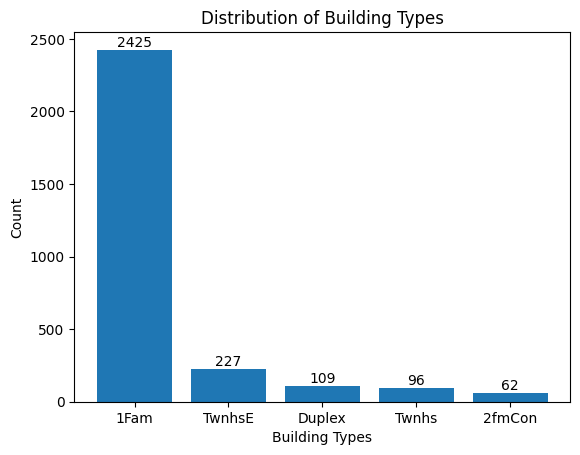

In [14]:
# Create a bar chart to see the distribution of building types 

dwelling_types = df_full['BldgType'].value_counts()

fig, ax = plt.subplots()
bars = ax.bar(dwelling_types.index, dwelling_types.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Building Types')
ax.set_ylabel('Count')
ax.set_title('Distribution of Building Types')

Text(0.5, 1.0, 'Average Sale Price by Building Type')

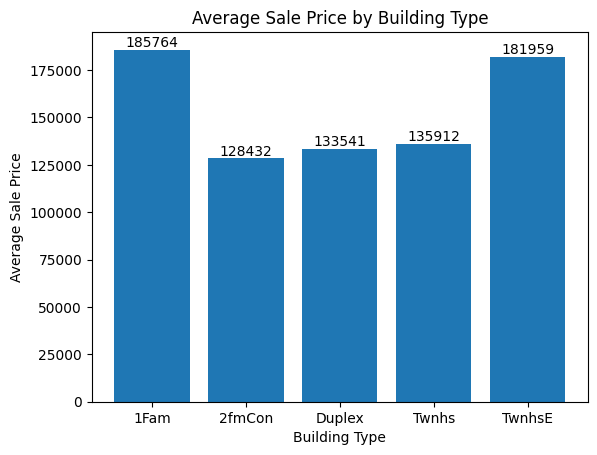

In [15]:
# Average Sale Price by Building Types

dwelling_prices = df_full.groupby('BldgType')['SalePrice'].mean()

fig, ax = plt.subplots()
bars = ax.bar(dwelling_prices.index, dwelling_prices.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Building Type')
ax.set_ylabel('Average Sale Price')
ax.set_title('Average Sale Price by Building Type')

Text(0.5, 1.0, 'Average Sale Price by Zoning')

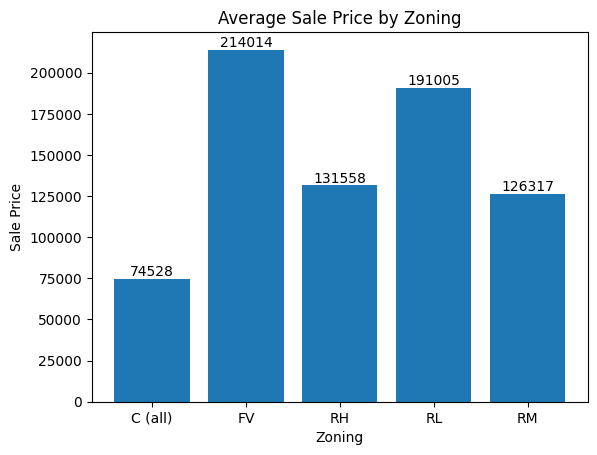

In [16]:
# Zoning impact on sale price

zoning_prices = df_full.groupby('MSZoning')['SalePrice'].mean()

fig, ax = plt.subplots()
bars = ax.bar(zoning_prices.index, zoning_prices.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Zoning')
ax.set_ylabel('Sale Price')
ax.set_title('Average Sale Price by Zoning')

Text(0.5, 1.0, 'Sale Price Trends Over the Years')

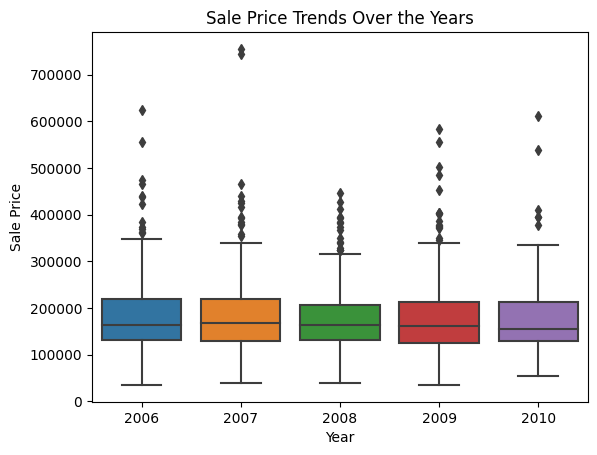

In [17]:
# Sale Price Trends Over the Years

ax = sns.boxplot(data = df_full,
                 x = df_full["YrSold"], 
                 y = df_full["SalePrice"])

# Add some text for labels, title 
ax.set_xlabel('Year')
ax.set_ylabel('Sale Price')
ax.set_title('Sale Price Trends Over the Years')

Text(0.5, 1.0, 'Sale Price Trends By Months')

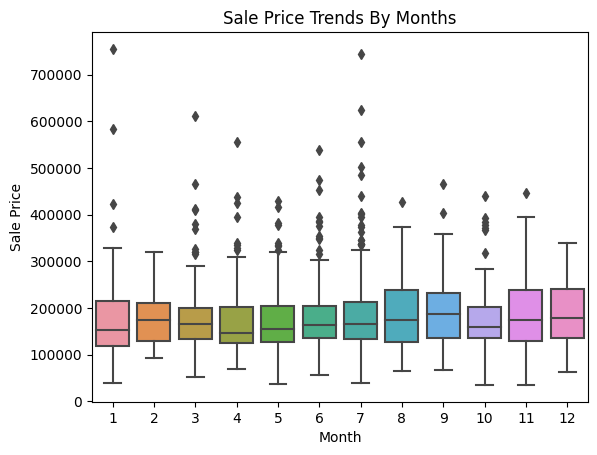

In [18]:
# Sale Price Trends By Months

ax = sns.boxplot(data = df_full,
                 x = df_full["MoSold"], 
                 y = df_full["SalePrice"])

# Add some text for labels, title 
ax.set_xlabel('Month')
ax.set_ylabel('Sale Price')
ax.set_title('Sale Price Trends By Months')

Text(0.5, 1.0, 'Average Sale Price by Sale Conditions')

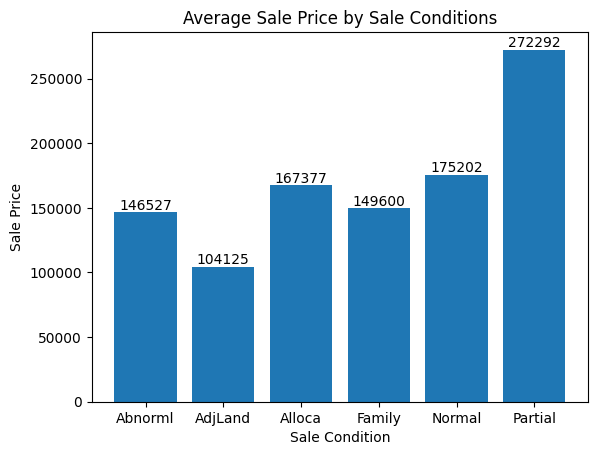

In [19]:
# Sale condition impact on sale price

sale_condition_prices = df_full.groupby('SaleCondition')['SalePrice'].mean()

fig, ax = plt.subplots()
bars = ax.bar(sale_condition_prices.index, sale_condition_prices.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Sale Condition')
ax.set_ylabel('Sale Price')
ax.set_title('Average Sale Price by Sale Conditions')

Text(0.5, 1.0, 'Distribution of Sale Conditions')

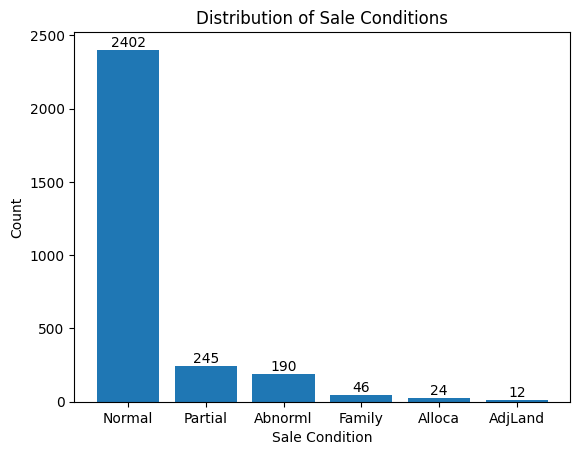

In [20]:
# The distribution of Sale Conditions 

sale_condition_count = df_full['SaleCondition'].value_counts()

fig, ax = plt.subplots()
bars = ax.bar(sale_condition_count.index, sale_condition_count.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Sale Condition')
ax.set_ylabel('Count')
ax.set_title('Distribution of Sale Conditions')

Text(0.5, 1.0, 'Average Sale Price by Overall Quality')

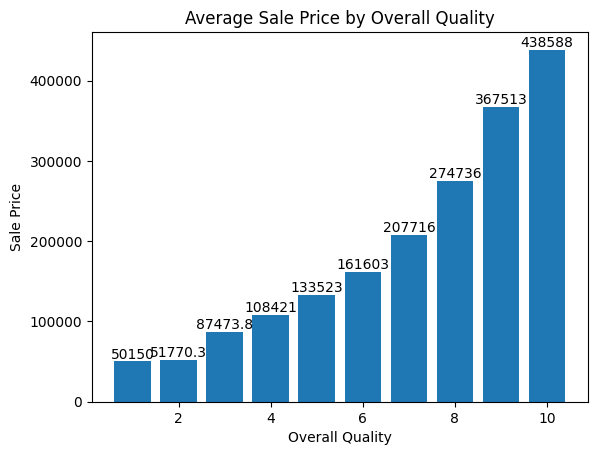

In [21]:
# The Overall material and finish quality impact on sale price

overall_quality = df_full.groupby('OverallQual')['SalePrice'].mean()

fig, ax = plt.subplots()
bars = ax.bar(overall_quality.index, overall_quality.values)
ax.bar_label(bars)

# Add some text for labels, title 
ax.set_xlabel('Overall Quality')
ax.set_ylabel('Sale Price')
ax.set_title('Average Sale Price by Overall Quality')

<Axes: xlabel='SalePrice', ylabel='Count'>

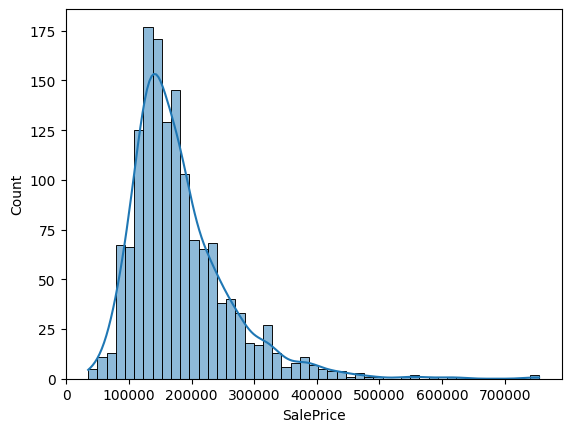

In [22]:
# The Distribution of SalePrice (Target variable)

sns.histplot(df_full['SalePrice'], kde=True)

<Axes: >

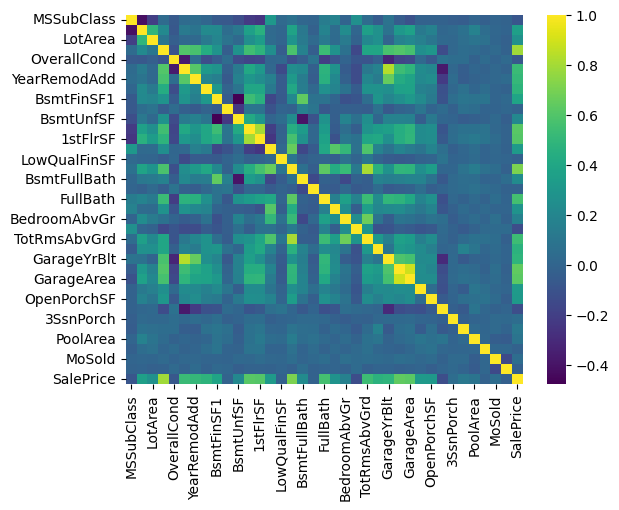

In [23]:
# Display the correlation between variables

sns.heatmap(df_full.corr(numeric_only=True),cmap="viridis")

In [24]:
# The correlation to Sale Price

df_full.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).to_frame()

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


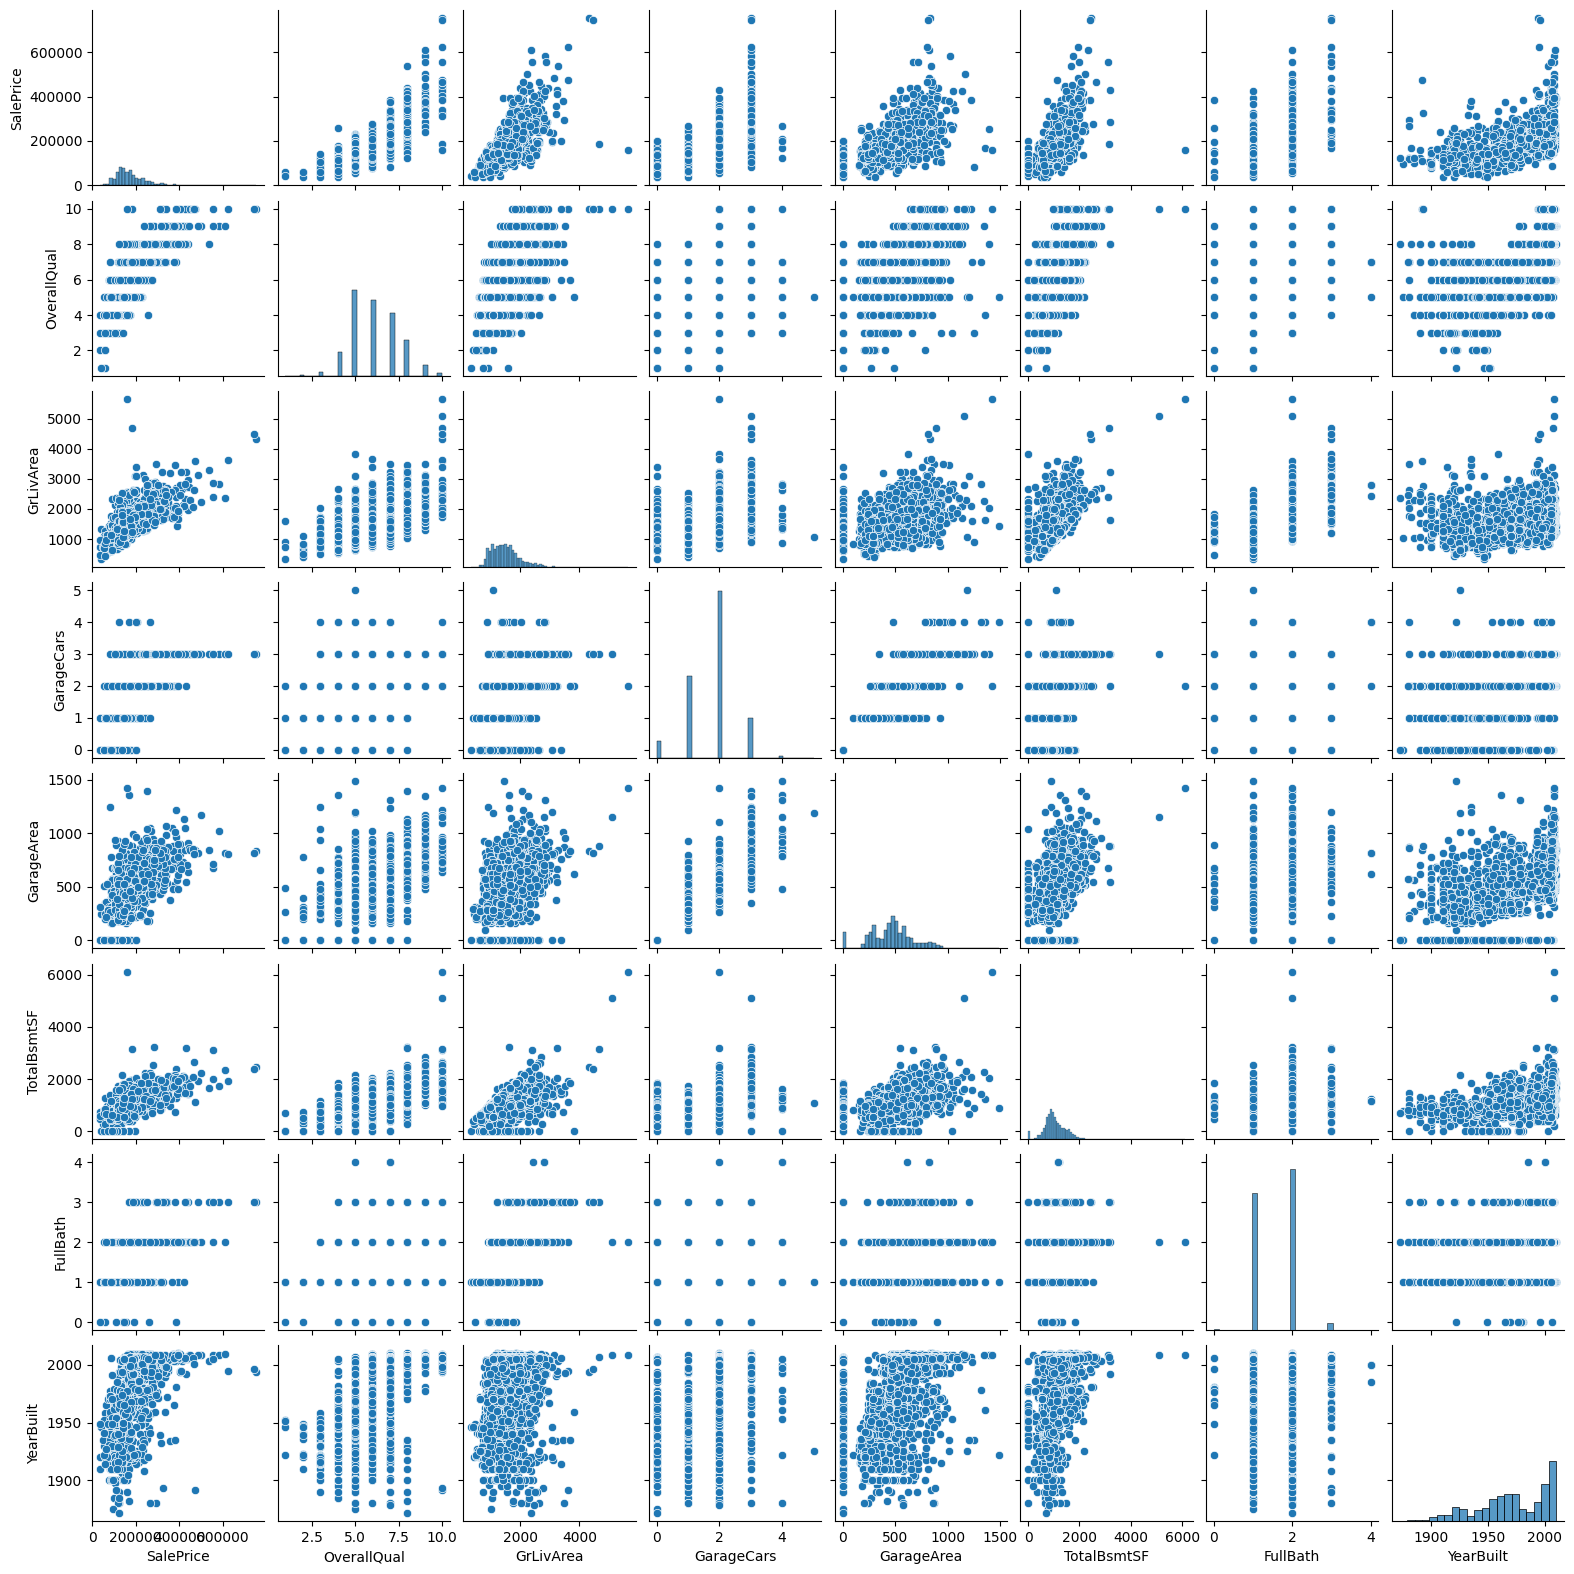

In [25]:
# Create pairplot by select the feature that have the most correlation with sale price

selected_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.pairplot(data=df_full[selected_features], height=2)

# Data Preprocessing

In [26]:
# Get the name of the columns

df_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [27]:
# Renames the columns that have the begining with Numbers change into Alphabets
# (Optional)

df_full.rename(columns={'1stFlrSF': 'FirstFlrSF',
                        '2ndFlrSF': 'SecondFlrSF',
                        '3SsnPorch': 'Threeseasonporch'}, 
               inplace=True)

In [28]:
# Check the name of the columns again

df_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive'

In [29]:
# Check the data types 

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2919 non-null   int64  
 1   MSZoning          2915 non-null   object 
 2   LotFrontage       2433 non-null   float64
 3   LotArea           2919 non-null   int64  
 4   Street            2919 non-null   object 
 5   Alley             198 non-null    object 
 6   LotShape          2919 non-null   object 
 7   LandContour       2919 non-null   object 
 8   Utilities         2917 non-null   object 
 9   LotConfig         2919 non-null   object 
 10  LandSlope         2919 non-null   object 
 11  Neighborhood      2919 non-null   object 
 12  Condition1        2919 non-null   object 
 13  Condition2        2919 non-null   object 
 14  BldgType          2919 non-null   object 
 15  HouseStyle        2919 non-null   object 
 16  OverallQual       2919 non-null   int64  
 17  

In [30]:
# Convert non-numeric predictors stored as numbers into string

df_full['MSSubClass'] = df_full['MSSubClass'].apply(str)
df_full['YrSold'] = df_full['YrSold'].apply(str)
df_full['MoSold'] = df_full['MoSold'].apply(str)

In [31]:
# Check the data types again

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2919 non-null   object 
 1   MSZoning          2915 non-null   object 
 2   LotFrontage       2433 non-null   float64
 3   LotArea           2919 non-null   int64  
 4   Street            2919 non-null   object 
 5   Alley             198 non-null    object 
 6   LotShape          2919 non-null   object 
 7   LandContour       2919 non-null   object 
 8   Utilities         2917 non-null   object 
 9   LotConfig         2919 non-null   object 
 10  LandSlope         2919 non-null   object 
 11  Neighborhood      2919 non-null   object 
 12  Condition1        2919 non-null   object 
 13  Condition2        2919 non-null   object 
 14  BldgType          2919 non-null   object 
 15  HouseStyle        2919 non-null   object 
 16  OverallQual       2919 non-null   int64  
 17  

In [32]:
# Check the columns that have missing values

df_full.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
BsmtFullBath        2
Functional          2
Exterior2nd         1
Exterior1st         1
GarageArea          1
GarageCars          1
SaleType            1
KitchenQual         1
BsmtFinSF1          1
Electrical          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
TotRmsAbvGrd        0
Fireplaces          0
SaleCondition       0
PavedDrive          0
MoSold              0
dtype: int64

In [33]:
# Fill the missing values with the data that we know how to fill due to the *Description File*

df_full['Functional'] = df_full['Functional'].fillna('Typ')
df_full['Electrical'] = df_full['Electrical'].fillna("SBrkr")
df_full['KitchenQual'] = df_full['KitchenQual'].fillna("TA")
df_full['Exterior1st'] = df_full['Exterior1st'].fillna(df_full['Exterior1st'].mode()[0])
df_full['Exterior2nd'] = df_full['Exterior2nd'].fillna(df_full['Exterior2nd'].mode()[0])
df_full['SaleType'] = df_full['SaleType'].fillna(df_full['SaleType'].mode()[0])
df_full["PoolQC"] = df_full["PoolQC"].fillna("None")
df_full["Alley"] = df_full["Alley"].fillna("None")
df_full['FireplaceQu'] = df_full['FireplaceQu'].fillna("None")
df_full['Fence'] = df_full['Fence'].fillna("None")
df_full['MiscFeature'] = df_full['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    df_full[col] = df_full[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_full[col] = df_full[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_full[col] = df_full[col].fillna('None')
    

In [34]:
# Check the columns with missing values again

missing_remained = df_full.isnull().sum().sort_values(ascending=False).head(20)
missing_remained

MasVnrType      1766
SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
TotalBsmtSF        1
Fireplaces         0
Functional         0
TotRmsAbvGrd       0
KitchenQual        0
KitchenAbvGr       0
MiscFeature        0
GarageType         0
dtype: int64

In [35]:
# Explore the data types of the columns that have missing values

df_full[missing_remained.index].dtypes

MasVnrType       object
SalePrice       float64
LotFrontage     float64
GarageYrBlt     float64
MasVnrArea      float64
MSZoning         object
Utilities        object
BsmtHalfBath    float64
BsmtFullBath    float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
TotalBsmtSF     float64
Fireplaces        int64
Functional       object
TotRmsAbvGrd      int64
KitchenQual      object
KitchenAbvGr      int64
MiscFeature      object
GarageType       object
dtype: object

In [36]:
# The missing values that not included in the Description File:
# For numeric values: Fill the missing values with 0
# For categorical values: Fill the missing values with "None" 

for name in df_full.select_dtypes("number"):
        df_full[name] = df_full[name].fillna(0)
        
for name in df_full.select_dtypes("object"):
        df_full[name] = df_full[name].fillna("None")

In [37]:
# Check columns with missing values again

df_full.isnull().sum().sort_values(ascending=False).head(10)

MSSubClass      0
MSZoning        0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

# FEATURE ENGINEERING

In [38]:
df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0


In [39]:
# Mathematical transforms

df_full["LivLotRatio"] = df_full["GrLivArea"] / df_full["LotArea"]
df_full["Spaciousness"] = (df_full["FirstFlrSF"] + df_full["SecondFlrSF"]) / df_full["TotRmsAbvGrd"]
df_full["SqFtPerRoom"] = df_full["GrLivArea"] / (df_full["TotRmsAbvGrd"] +
                                                df_full["FullBath"] +
                                                df_full["HalfBath"] +
                                                df_full["KitchenAbvGr"])

df_full["Total_Home_Quality"] = df_full["OverallQual"] + df_full["OverallCond"]

df_full["Total_Bathrooms"] = (df_full["FullBath"] + (0.5 * df_full["HalfBath"]) +
                               df_full["BsmtFullBath"] + (0.5 * df_full["BsmtHalfBath"]))

df_full["HighQualSF"] = df_full["GrLivArea"] + df_full["FirstFlrSF"] + df_full["SecondFlrSF"] + 0.5 * df_full["GarageArea"] + 0.5 * df_full["TotalBsmtSF"] + 1 * df_full["MasVnrArea"]

df_full["Age"] = pd.to_numeric(df_full["YrSold"]) - pd.to_numeric(df_full["YearBuilt"])

df_full["Renovate"] = pd.to_numeric(df_full["YearRemodAdd"]) - pd.to_numeric(df_full["YearBuilt"])

# Counts
df_full["PorchTypes"] = df_full[["WoodDeckSF","OpenPorchSF","EnclosedPorch","Threeseasonporch","ScreenPorch",]].gt(0.0).sum(axis=1)

# Group transforms
df_full["MedNhbdArea"] = df_full.groupby("Neighborhood")["GrLivArea"].transform("median")


In [40]:
df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,LivLotRatio,Spaciousness,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,Age,Renovate,PorchTypes,MedNhbdArea
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0.202367,213.750000,142.500000,12,3.5,4318.0,5,0,1,1504.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0.131458,210.333333,140.222222,14,2.5,3385.0,31,0,1,1706.5
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0.158756,297.666667,178.600000,12,3.5,4498.0,7,1,1,1504.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0.179791,245.285714,190.777778,12,2.0,4133.0,91,55,2,1648.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0.154137,244.222222,169.076923,13,3.5,5736.5,8,0,2,2418.0


In [41]:
# Create dummy variables for categorical features

df_full_dummies = pd.get_dummies(df_full)

In [42]:
df_full_dummies.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,False,False,False,True,False,False,False,False,True,False
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,False,False,False,True,False,False,False,False,True,False
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,False,False,False,True,False,False,False,False,True,False
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,False,False,False,True,True,False,False,False,False,False
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,False,False,False,True,False,False,False,False,True,False


In [43]:
# Reform splits 

df_train = df_full_dummies.loc[df_train.index, :]

df_test = df_full_dummies.loc[df_test.index, :]

df_test.drop('SalePrice', axis=1, inplace=True)

In [44]:
# Select X = Columns as Features

X = df_train.drop('SalePrice', axis=1)

# Select y = Target Variable

target = df_train['SalePrice']
y = np.log(target)

# We need to log-transform y to train and exp-transform the predictions

In [45]:
# Train-test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2)

# Creating the Model

In [46]:
# Create a function for the score of root mean square error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [47]:
# Cat Boost Regression

cat_model = CatBoostRegressor(n_estimators=1000, 
                              learning_rate= 0.02, 
                              max_depth=5,
                              verbose=False,
                              model_size_reg=0.7,
                              subsample=0.44,
                              random_strength=1.5,
                              loss_function='RMSE',
                              random_state=2)

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_valid)
cat_score = rmse(y_valid, cat_pred)
cat_score

0.11848767499970402

In [48]:
# Gradient Boosting Regression

gbr_model = GradientBoostingRegressor(n_estimators=1000,
                                      learning_rate=0.02, 
                                      max_depth=5, 
                                      min_samples_split=2, 
                                      max_features=35, 
                                      random_state=2)

gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_valid)
gbr_score = rmse(y_valid, gbr_pred)
gbr_score

0.11971656527155931

In [49]:
# Light gradient boosting method regression

lgbm_model = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1)

                         
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_valid)
lgbm_score = rmse(y_valid, lgbm_pred)
lgbm_score

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.12543404179795134

In [50]:
# Extreme Gradient Boosting Regression

xgb_model = XGBRegressor(n_estimators=2000,
                         learning_rate=0.01, 
                         max_depth=5, 
                         min_child_weight=1,
                         gamma=0, 
                         subsample=0.7,
                         colsample_bytree=0.7,
                         objective='reg:squarederror', 
                         nthread=-1,
                         scale_pos_weight=1, 
                         seed=27,
                         reg_alpha=0.00006)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)
xgb_score = rmse(y_valid, xgb_pred)
xgb_score

0.12211183252293996

In [51]:
# Random Forest Regression

rf_model = RandomForestRegressor(n_estimators=1000,
                                 max_depth=None,
                                 max_features=1.0, 
                                 criterion='squared_error', 
                                 min_samples_split=2, 
                                 min_samples_leaf=3,
                                 min_weight_fraction_leaf=0.0, 
                                 random_state=2)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_valid)
rf_score = rmse(y_valid, rf_pred)
rf_score

0.14258264868502313

In [52]:
# Decision Tree Regression

dt_model = DecisionTreeRegressor(criterion='squared_error',
                                 max_depth=None, 
                                 min_samples_split=2, 
                                 min_samples_leaf=3,
                                 min_weight_fraction_leaf=0.0, 
                                 max_features=None, 
                                 splitter="best",
                                 random_state=2)
    
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_valid)
dt_score = rmse(y_valid, dt_pred)
dt_score

0.19405718608733208

In [53]:
# Linear Regression

ln_model = LinearRegression()

ln_model.fit(X_train, y_train)
ln_pred = ln_model.predict(X_valid)
ln_score = rmse(y_valid, ln_pred)
ln_score

0.15573750764993516

In [54]:
print("CAT :",cat_score,"\n",
      "GBR :",gbr_score,"\n",
      "XGB :",xgb_score,"\n",
      "LGBM :",lgbm_score,"\n", 
      "RF :",rf_score,"\n",
      "LN :", ln_score,"\n",
      "DT :",dt_score
      )

CAT : 0.11848767499970402 
 GBR : 0.11971656527155931 
 XGB : 0.12211183252293996 
 LGBM : 0.12543404179795134 
 RF : 0.14258264868502313 
 LN : 0.15573750764993516 
 DT : 0.19405718608733208


# Stacking Model

In [55]:
# Define base models
base_models = [('cat', cat_model),
               ('gbr', gbr_model),
               ('xgb', xgb_model), 
               ('lgbm', lgbm_model)
              ]

# Define meta-model
meta_model = LinearRegression()

# Create the stacking model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [56]:
# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions on the training data
stacked_train_predictions = stacked_model.predict(X_valid)

# Calculate RMSE
stacked_score = rmse(y_valid, stacked_train_predictions)
stacked_score

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

0.11746297314769195

In [57]:
# Make predictions on the test dataset

stacked_predictions = np.exp(stacked_model.predict(df_test))

In [58]:
# Create a submission file

output = pd.DataFrame({'Id': df_test.index, 'SalePrice': stacked_predictions})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,121520.280263
1,1462,158409.502863
2,1463,184723.839614
3,1464,191353.593562
4,1465,188089.112328
